#### After each model for different n-grams there is an example of generated text. Unfortunately, all examples leave much to be desired
***
#### A final table with perplexity values for different models is provided below the application of different models.
***
#### At the end of the file there is an attempt to use Markov chain and links to sources, which were used in this work

In [528]:
import lyricsgenius
import json
import pandas as pd
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
nltk.download('punkt')
from nltk.lm.preprocessing import flatten
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.lm import KneserNeyInterpolated 
from nltk.lm import Laplace
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk import word_tokenize, sent_tokenize 
import textwrap

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Forest_Gump\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### The chunk below was commented after the work was done in order not to waste space on GitHub

In [401]:
#Checking whether installed module works correctly, setting Eminem as the author
genius = lyricsgenius.Genius("jHJB8vqrbfVDIGM1KrETFx6s7EG9SGN3RGcmr63z7Gjgz8dYY4LizTL9rGupTAl1")
#at first used to sort by title, but it brings remixes of same song, so let us sort by popularity 
#artist = genius.search_artist("Eminem", max_songs=400, sort="popularity")
#genius.remove_section_headers = True
#genius.verbose = False
#artist.save_lyrics()

In [90]:
#open the file and have a look at keys
lyrics = 'Lyrics_Eminem.json'
with open(lyrics) as eminem_lyrics:
    messyvocab = json.load(eminem_lyrics)
dict_keys = messyvocab.keys()
print(dict_keys)

dict_keys(['alternate_names', 'api_path', 'description', 'facebook_name', 'followers_count', 'header_image_url', 'id', 'image_url', 'instagram_name', 'is_meme_verified', 'is_verified', 'name', 'translation_artist', 'twitter_name', 'url', 'current_user_metadata', 'iq', 'description_annotation', 'user', 'songs'])


In [453]:
#extracting songs' lyrics and form a vocabulary
vocab = messyvocab.get('songs')
lyrics_vocab = []
for i in range(0,len(vocab)):
    index = vocab[i]
    song = index.get('lyrics')
    lyrics_vocab.append(song)
lyricsdf = pd.DataFrame(lyrics_vocab, columns=['Song lyrics'])
lyricsdf = lyricsdf.dropna()
#clear the punctuation
for i in range(0,len(lyricsdf)):
    stringlyric = lyricsdf.iloc[i,0]
    for x in ['intro', 'verse', 'chorus','!','"', "'", '’', '#','$','%','&','(',')','*','+',',','-','/',':',';','<','=','>','?','@','[','\\',']',
 '^','_','`','{','|','}','~', '1', '...']:   
        stringlyric = stringlyric.replace(x, '')
        lyricsdf.iloc[i,0] = stringlyric
#lowercasing and tokenization 
lyricsdf['Song lyrics'] = lyricsdf['Song lyrics'].str.lower()
lyricsdf['lyr_token'] = lyricsdf.apply(lambda row: nltk.word_tokenize(row['Song lyrics']), axis=1)
#forming a list with tokenized lyrics
tokenized_text = lyricsdf['lyr_token'].tolist()

Text(0.5, 1.0, 'Top 20 word in Eminem rap lyrics')

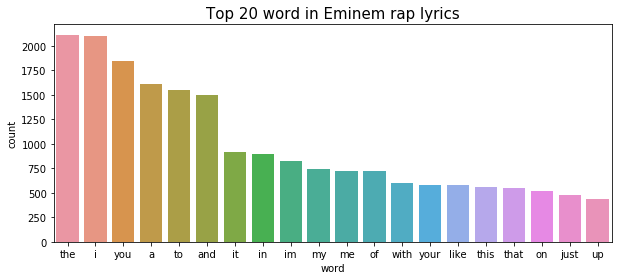

In [491]:
flattened_list = []
for x in tokenized_text:
    for y in x:
        flattened_list.append(y)
word_count = Counter(flattened_list).most_common(20)
word_count_df = pd.DataFrame(word_count, columns = ['word', 'count'])

#creating a plot, depicting words distribution
fig, (ax) = plt.subplots(figsize = (10, 4))
sns.barplot(x = word_count_df['word'], y = word_count_df['count'], ax = ax)
ax.set_ylabel('count', fontsize = 10)
ax.set_xlabel('word',fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_title('Top 20 word in Eminem rap lyrics', fontsize = 15)

#### As we know, the bigger is testset, the better, therefore let's set the size of 60%

In [454]:
train, test = train_test_split(tokenized_text, test_size=0.6, random_state=11)

#### At first I used only 400 Eminem's songs, and got pretty high perplexity. Then it was decided to expand train set in order to get better perplexity, so below I append to train set the lyrics of 50 Cent's, since the Internet told me they are quite similar to Eminem's. I have searched for and downloaded .json with his lyrics before, so now let's upload some more rap

In [261]:
#same procedure as with Eminem's lyrics, we open the file and look at the keys
cent_lyrics = 'Lyrics_50Cent.json'
with open(cent_lyrics) as fifty_cent_lyrics:
    centmessyvocab = json.load(fifty_cent_lyrics)
dict_keys = centmessyvocab.keys()
print(dict_keys)

dict_keys(['alternate_names', 'api_path', 'description', 'facebook_name', 'followers_count', 'header_image_url', 'id', 'image_url', 'instagram_name', 'is_meme_verified', 'is_verified', 'name', 'translation_artist', 'twitter_name', 'url', 'current_user_metadata', 'iq', 'description_annotation', 'user', 'songs'])


In [262]:
#extracting songs' lyrics and form a vocabulary
vocab = centmessyvocab.get('songs')
cent_lyrics_vocab = []
for i in range(0,len(vocab)):
    index = vocab[i]
    song = index.get('lyrics')
    cent_lyrics_vocab.append(song)
centlyricsdf = pd.DataFrame(cent_lyrics_vocab, columns=['Song lyrics'])
centlyricsdf = centlyricsdf.dropna()
#clear the punctuation
for i in range(0,len(centlyricsdf)):
    stringlyric = centlyricsdf.iloc[i,0]
    for x in ['intro', 'verse', 'chorus','!','"', "'", '’', '#','$','%','&','(',')','*','+',',','-','/',':',';','<','=','>','?','@','[','\\',']',
 '^','_','`','{','|','}','~', '1', '...']:   
        stringlyric = stringlyric.replace(x, '')
        centlyricsdf.iloc[i,0] = stringlyric
#lowercasing and tokenization 
centlyricsdf['Song lyrics'] = centlyricsdf['Song lyrics'].str.lower()
centlyricsdf['lyr_token'] = centlyricsdf.apply(lambda row: nltk.word_tokenize(row['Song lyrics']), axis=1)
#forming a list with tokenized lyrics of 50Cent which will be appended to train set
append_to_train_50cent = centlyricsdf['lyr_token'].tolist()

In [455]:
#expanding the train set
for x in append_to_train_50cent:
    train.append(x)

### 1-grams

In [411]:
n=1

#### Kneser-Ney Interpolated for unigrams, default value of discount = 0.1

In [459]:
train_data_1_KN, padded_sents_1_KN = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_unigrams_KN = ngrams(test_grams.split(), n)
unigrams_KN_test = []
for grams in test_unigrams_KN:
    unigrams_KN_test.append(grams)
unigrams_KN_test = tuple(unigrams_KN_test)

In [460]:
model_1_KN = KneserNeyInterpolated(n, discount=0.1)

In [461]:
model_1_KN.fit(train_data_1_KN, padded_sents_1_KN)

In [462]:
model_1_KN.perplexity(unigrams_KN_test)

9394.999999950445

#### Kneser-Ney Interpolated for unigrams, set value of discount = 0.9

In [463]:
train_data_9_KN, padded_sents_9_KN = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_unigrams_KN9 = ngrams(test_grams.split(), n)
unigrams_KN9_test = []
for grams in test_unigrams_KN9:
    unigrams_KN9_test.append(grams)
unigrams_KN9_test = tuple(unigrams_KN9_test)

In [464]:
model_1_KN_9 = KneserNeyInterpolated(n, discount=0.9)

In [465]:
model_1_KN_9.fit(train_data_9_KN, padded_sents_9_KN)

In [467]:
Unigram_KN_PP = model_1_KN_9.perplexity(unigrams_KN9_test)
Unigram_KN_PP

9394.999999950445

In [468]:
print(model_1_KN_9.generate(10, random_seed=1))

['bullshit', 'steps', 'sclass', 'dialing', 'klepto', 'hyper', 'pegged', 'shopper', 'birth', 'age']


In [403]:
#As we can see above, simple generation shows separate words, therefore, new function is included below
#which is fully copypasted from https://www.kaggle.com/alvations/n-gram-language-model-with-nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [281]:
for i in range(3):
    print(generate_sent(model_1_KN_9, 10, random_seed=i))

station sat heezy dimes learned ha.. shifty entertain jesus monopolize
bullshit steps sclass dialing klepto hyper pegged shopper birth age
wait vicious attacks bendin sprigs rikers please even newport nicest


#### Laplace model for unigrams

In [283]:
train_data_LA, padded_sents_LA = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_unigrams_LA = ngrams(test_grams.split(), n)
unigrams_LA_test = []
for grams in test_unigrams_LA:
    unigrams_LA_test.append(grams)
unigrams_LA_test = tuple(unigrams_LA_test)

In [284]:
model_laplace = Laplace(n)

In [285]:
model_laplace.fit(train_data_LA, padded_sents_LA)

In [286]:
#It makes me wanna cry too
model_laplace.perplexity(unigrams_LA_test)

154122.00000158613

In [384]:
Unigram_laplace_PP = model_laplace.perplexity(unigrams_LA_test)

In [288]:
#Let's look at examples of text generation
for i in range(3):
    print(generate_sent(model_laplace, 10, random_seed=i))

tip style in from man im thats got lay nigga
buttered to ta forth livin its pippen the be a
year writin and back this so quick gun o of


#### MLE for unigrams

In [289]:
train_data_MLE, padded_sents_MLE = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_unigrams_MLE = ngrams(test_grams.split(), n)
unigrams_MLE_test = []
for grams in test_unigrams_MLE:
    unigrams_MLE_test.append(grams)
unigrams_MLE_test = tuple(unigrams_MLE_test)

In [290]:
model_MLE = MLE(n)

In [291]:
model_MLE.fit(train_data_MLE, padded_sents_MLE)

In [292]:
#Unfortunately, it is infinite because of unknowkn n-grams in test set
model_MLE.perplexity(unigrams_MLE_test)

inf

In [385]:
Unigram_mle_PP = model_MLE.perplexity(unigrams_MLE_test)

In [293]:
#Let's look at examples of text generation
for i in range(3):
    print(generate_sent(model_MLE, 10, random_seed=i))

to take in fuckin man im the gunshot legal nigga
buzzed to testarossa fuck long its plain the be a
york ya and baby through son rap happy of of


### 2-grams

In [338]:
n=2

#### Kneser-Ney Interpolated for bigrams, default value of discount = 0.1

In [347]:
train_data_1_KN_2, padded_sents_1_KN_2 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_bigrams_KN = ngrams(test_grams.split(), n)
bigrams_KN_test = []
for grams in test_bigrams_KN:
    bigrams_KN_test.append(grams)
bigrams_KN_test = tuple(bigrams_KN_test)

In [348]:
model_2_KN = KneserNeyInterpolated(n, discount=0.1)

In [349]:
model_2_KN.fit(train_data_1_KN_2, padded_sents_1_KN_2)

In [350]:
model_2_KN.perplexity(bigrams_KN_test)

9397.000000039661

#### Kneser-Ney Interpolated for bigrams, set value of discount = 0.9

In [351]:
train_data_9_KN_2, padded_sents_9_KN_2 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_bigrams_KN9 = ngrams(test_grams.split(), n)
bigrams_KN9_test = []
for grams in test_bigrams_KN9:
    bigrams_KN9_test.append(grams)
bigrams_KN9_test = tuple(bigrams_KN9_test)

In [352]:
model_2_KN_9 = KneserNeyInterpolated(n, discount=0.9)

In [353]:
model_2_KN_9.fit(train_data_9_KN_2, padded_sents_9_KN_2)

In [354]:
model_2_KN_9.perplexity(bigrams_KN9_test)

9397.000000039661

In [386]:
Bigram_KN_PP = model_2_KN_9.perplexity(bigrams_KN9_test)

In [358]:
#Let's look at examples of text generation
for i in [5,6,7,8]:
    print(generate_sent(model_2_KN_9, 10, random_seed=i))

officer rickyyyyyyyyyyyyyyyyyyyyyyyyyyyyy verse man ran up against me you my
shutting you in love 50 cent kardinal offishall eeny meany
fantasies they ready everybody knows everyone knows like a lie
crowned you call rider im doin what i like its


#### Laplace model for bigrams

In [359]:
train_data_LA_2, padded_sents_LA_2 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_bigrams_LA = ngrams(test_grams.split(), n)
bigrams_LA_test = []
for grams in test_bigrams_LA:
    bigrams_LA_test.append(grams)
bigrams_LA_test = tuple(bigrams_LA_test)

In [360]:
model_laplace_2 = Laplace(n)

In [361]:
model_laplace_2.fit(train_data_LA_2, padded_sents_LA_2)

In [363]:
#Really huge
model_laplace_2.perplexity(bigrams_LA_test)

9397.000000039661

In [387]:
Bigram_laplace_PP = model_laplace_2.perplexity(bigrams_LA_test)

In [364]:
#Let's look at examples of text generation
for i in [5,6,7,8]:
    print(generate_sent(model_laplace_2, 10, random_seed=i))

on the showroom floor now yeah
the spot on it . pay her she got that
head boy tony and many many calibers here and im
em where canibus wannafuck your bowels when it


#### MLE for bigrams

In [365]:
train_data_MLE_2, padded_sents_MLE_2 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_bigrams_MLE = ngrams(test_grams.split(), n)
bigrams_MLE_test = []
for grams in test_bigrams_MLE:
    bigrams_MLE_test.append(grams)
bigrams_MLE_test = tuple(bigrams_MLE_test)

In [366]:
model_MLE_2 = MLE(n)

In [367]:
model_MLE_2.fit(train_data_MLE_2, padded_sents_MLE_2)

In [369]:
model_MLE_2.perplexity(bigrams_MLE_test)

inf

In [388]:
Bigram_mle_PP=model_MLE_2.perplexity(bigrams_MLE_test)

In [370]:
#Let's look at examples of text generation via MLE for bigrams
for i in [9,10,11]:
    print(generate_sent(model_MLE_2, 10, random_seed=i))

kid in court throwing money man what goes into my
nasty girl louie checkers these rap shit clear off life
its most rawest form of pot ill kill whats up


### 3-grams

In [371]:
n=3

#### Kneser-Ney Interpolated for trigrams, default value of discount = 0.1

In [372]:
train_data_1_KN_3, padded_sents_1_KN_3 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_trigrams_KN = ngrams(test_grams.split(), n)
trigrams_KN_test = []
for grams in test_trigrams_KN:
    trigrams_KN_test.append(grams)
trigrams_KN_test = tuple(trigrams_KN_test)

In [373]:
model_3_KN = KneserNeyInterpolated(n, discount=0.1)

In [374]:
model_3_KN.fit(train_data_1_KN_3, padded_sents_1_KN_3)

In [375]:
model_3_KN.perplexity(trigrams_KN_test)

9397.000000039661

In [389]:
Trigram_KN_PP = model_3_KN.perplexity(trigrams_KN_test)

In [376]:
#Let's look at examples of text generation
for i in range(3):
    print(generate_sent(model_3_KN, 10, random_seed=i))

station witness 2 i got moneymoney i got my name
bulls out i dont know what you sayin boy you
wait wait for doctor to get shit confused i wasnt


As our previous experience shows us, setting different discounts have no effect, so we will look only at default value of d

#### Laplace model for trigrams

In [377]:
train_data_LA_3, padded_sents_LA_3 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_trigrams_LA = ngrams(test_grams.split(), n)
trigrams_LA_test = []
for grams in test_trigrams_LA:
    trigrams_LA_test.append(grams)
trigrams_LA_test = tuple(trigrams_LA_test)

In [378]:
model_laplace_3 = Laplace(n)

In [379]:
model_laplace_3.fit(train_data_LA_3, padded_sents_LA_3)

In [380]:
model_laplace_3.perplexity(trigrams_LA_test)

9397.000000039661

In [382]:
Trigram_laplace_PP = model_laplace_3.perplexity(trigrams_LA_test)

In [381]:
#Let's look at examples of text generation
for i in [5,6,7,8]:
    print(generate_sent(model_laplace_3, 10, random_seed=i))

on the sidewalk red with the animal hook 50 cent
the spot right now . listen i went from sugar
he came home actin like i aint hurting im aight
eighties and a nigga bout when you cross me im


#### MLE for trigrams

In [390]:
train_data_MLE_3, padded_sents_MLE_3 = padded_everygram_pipeline(n, train)
test_grams = str(test)
test_trigrams_MLE = ngrams(test_grams.split(), n)
trigrams_MLE_test = []
for grams in test_trigrams_MLE:
    trigrams_MLE_test.append(grams)
trigrams_MLE_test = tuple(trigrams_MLE_test)

In [391]:
model_MLE_3 = MLE(n)

In [392]:
model_MLE_3.fit(train_data_MLE_3, padded_sents_MLE_3)

In [393]:
model_MLE_3.perplexity(trigrams_MLE_test)

inf

In [394]:
Trigram_mle_PP = model_MLE_3.perplexity(trigrams_MLE_test)

In [395]:
#Let's look at examples of text generation via MLE for trigrams
for i in [9,10,11]:
    print(generate_sent(model_MLE_3, 10, random_seed=i))

keep it girl you a lot of gats testin macks
na hear that chorus shorty you dont have nothing no
its most purest most rawest form flow almost flawless most


#### Creating a table with results for each of n-grams

In [559]:
compare = {'N-grams':['1-gram', '2-gram', '3-gram'],
        'Kneser-Ney PP': [Unigram_KN_PP,Bigram_KN_PP,Trigram_KN_PP],
        'Laplace PP': [Unigram_laplace_PP,Bigram_laplace_PP,Trigram_laplace_PP],
        'MLE PP': [Unigram_mle_PP,Bigram_mle_PP,Trigram_mle_PP] }
models = pd.DataFrame(compare, columns = ['N-grams', 'Kneser-Ney PP', 'Laplace PP', 'MLE PP'])
models_perplexity = models.style.set_table_styles([{'selector':'','props':[('border','4px solid #7a7'), ('font-family', 'verdana'),('font-family', 'verdana'), ('font-size', '120%')]}])
models_perplexity

,N-grams,Kneser-Ney PP,Laplace PP,MLE PP
0,1-gram,9395.000000,154122.000002,inf
1,2-gram,9397.000000,9397.000000,inf
2,3-gram,9397.000000,9397.000000,inf


### <span style="color:green">*Conclusion*</span>: perplexity, which indicates the quality of the model, is huge. Therefore, all used models are not that good (perhaps because of my mistakes). Tuning of discount in Kneser-Ney model did not make any changes in perplexity, which is strangely equal for different n-grams. Moreover, even after train set expansion, perplexity values did not become satisfactory. And, in general,  generated texts hardly resemble rap lyrics (unless the rapper is drunk), and look more like a set of random obscene words

I understand that there must me a lot of mistakes, but the whole task was quite cool thing to do

***

### Below there is an attempt to use principle of Markov chains for lyrics generation

In [560]:
tokenized_text = lyricsdf['lyr_token'].tolist()
flattened_lyr = []
for x in tokenized_text:
    for y in x:
        flattened_lyr.append(y)

def make_bigrams(text):
    for i in range(len(text)-1):
        yield (text[i], text[i+1])
        
bigrams = make_bigrams(flattened_lyr)

In [561]:
word_dict = {}

for word_1, word_2 in bigrams:
    if word_1 in word_dict.keys():
        word_dict[word_1].append(word_2)
    else:
        word_dict[word_1] = [word_2]
        
first_word = np.random.choice(flattened_lyr)

In [569]:
while first_word.islower():
    first_word = np.random.choice(flattened_lyr)

chain = [first_word]
n_words = 100

for i in range(n_words):
    chain.append(np.random.choice(word_dict[chain[-1]]))

generated_text = ' '.join(chain)
rap = textwrap.fill(generated_text, width=50)
 
print(rap)

2 met this fucking chick is to hurt you cave in
the pot make us together everything is on riding
on it trying to run deep as i had them some twins
before they say that i need somethin to outrun me
to toe from amityville hell stab in the panelin
cussin no paper i know where must go to think of
evil as i apologize if i have no help propel me
only women skinning your mom your verdict while i
get to dust and did you pissed me and if ten
freaky girls man ya sweeter than an mc


#### Unfortunately, I have no clue how to evaluate the quality of text generation, provided by this method. As far as I can judge, lyrics are not that bad, since there are many pairs and triples of words commonly used together, and some lines even make sense.

***

#### As it turned out, there occurs a fault when perplexity is counted, so either the other version of nltk should be installed, or it can be done as follows. I have updated my nltk version, but sometimes perplexity was still counted with mistakes, so I decided to include the source code below and use it when the error appears. 
(https://www.nltk.org/_modules/nltk/lm/api.html#LanguageModel) 

In [343]:
from nltk.lm.models import LanguageModel
#copypaste from NLTK source documentation
class InterpolatedLanguageModel(LanguageModel):
    def __init__(self, smoothing_cls, order, **kwargs):
        assert issubclass(smoothing_cls, Smoothing)
        params = kwargs.pop("params", {})
        super().__init__(order, **kwargs)
        self.estimator = smoothing_cls(self.vocab, self.counts, **params)


    def unmasked_score(self, word, context=None):
        if not context:
                return self.estimator.unigram_score(word)
        if not self.counts[context]:
             return self.unmasked_score(word, context[1:])
        alpha, gamma = self.estimator.alpha_gamma(word, context)
        return alpha + gamma * self.unmasked_score(word, context[1:])

In [344]:
def _count_non_zero_vals(dictionary):
    return sum(1.0 for c in dictionary.values() if c > 0)

In [345]:
#this is KneserNey from NLTK documentation but with some amendments from https://github.com/nltk/nltk/pull/2363/commits/ce74e449dc9526e19596b1c4a9c510bbb35812cc 
from nltk.lm.models import Smoothing
class KneserNey(Smoothing):
    def __init__(self, vocabulary, counter, discount=0.1, **kwargs):
        super(KneserNey, self).__init__(vocabulary, counter, *kwargs)
        super().__init__(vocabulary, counter, **kwargs)
        self.discount = discount

    def unigram_score(self, word):
        return 1.0 / len(self.vocab)

    def alpha_gamma(self, word, context):
        prefix_counts = self.counts[context]
        prefix_total_ngrams = prefix_counts.N()
        alpha = max(prefix_counts[word] - self.discount, 0.0) / prefix_total_ngrams
        gamma = self.discount * _count_non_zero_vals(prefix_counts) / prefix_total_ngrams
        return alpha, gamma

In [346]:
#copypaste from NLTK source documentation
class KneserNeyInterpolated(InterpolatedLanguageModel):
    def __init__(self, order, discount=0.1, **kwargs):
        super().__init__(KneserNey, order, params={"discount": discount}, **kwargs)

Heavily based on:
    https://www.kaggle.com/alvations/n-gram-language-model-with-nltk and https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6